In [13]:
#du/dx - cos(x) = 0

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math

rng = np.random.default_rng(seed=20)


In [14]:
n_wires=6
n_layers=3
load_filename='t1.npy'
save_filename='t1_prime.npy'
dev = qml.device('default.qubit', wires=n_wires)
loaded_params = np.load(load_filename)
print("Loaded parameters:", loaded_params)

Loaded parameters: [[[ 7.92584000e-01  4.96577578e-01  8.37177042e-01]
  [ 1.38276104e+00  3.17091963e-01  1.31062160e+00]
  [ 6.88898411e-01  1.58963135e+00  1.35568209e+00]
  [ 1.20298708e+00 -3.08182231e-02 -2.13950015e-01]
  [ 2.00370205e-01  1.40889514e+00  7.17912895e-01]
  [ 1.19105137e+00 -2.44736755e-01  7.34317968e-01]]

 [[ 9.90709265e-01  1.73111362e-01  9.10081104e-01]
  [ 2.42752426e-01  2.53181926e-01  8.80110991e-01]
  [ 2.78517236e-02 -1.73272272e-01  1.34624995e+00]
  [ 1.58273495e+00  2.13853515e-01  1.65867505e-01]
  [-7.87294873e-01  4.30168445e-01  8.16436361e-01]
  [ 1.10474445e+00  9.51624167e-02  3.96605144e-01]]

 [[ 6.50901271e-01  5.22517705e-01  3.57765485e-01]
  [ 6.69503303e-01  6.10103196e-01  5.11909830e-01]
  [ 9.34240159e-01  1.55753642e-01  6.27905706e-01]
  [ 9.44619540e-01  6.07381587e-04  6.43282023e-01]
  [ 7.82369448e-01  6.54766215e-01  6.07836611e-01]
  [-2.45987576e-02  3.99719470e-01  4.65603022e-01]]

 [[ 3.48967112e-01  3.45820436e-01  9.9

In [15]:
def phi(x, j):  # Chebyshev
    return 2 * j * np.arccos(x)

def dphi1(x,j):
    return 2*j*(-1 / np.sqrt(1 - x ** 2))

def dphi2(x,j):
    return 2*j*(-x / ((1 - x ** 2) ** (3 / 2)))

In [16]:
@qml.qnode(dev)
def u_x(x,parameters):
    # feature map
    for j in range(n_wires):
        qml.RY(phi=phi(x,j+1),wires=j)
    # ansatz
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(dev.num_wires)) 
    # Cost function <Z>
    return qml.expval(qml.PauliZ(0))

# shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_wires)
# w = rng.random(size=shape)
# print(qml.draw(u_x)(0.1,w))

In [17]:



@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def du_x_helper(phi_x_vector,parameters):
    # feature map
    for j in range(n_wires):
        qml.RY(phi_x_vector[j],wires=j)
    # ansatz
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(dev.num_wires)) 
    # Cost function <Z>
    return qml.expval(qml.PauliZ(0))

         
def du_x(x,parameters):
    phi_x=['Nan']*n_wires
    dphi_x=['Nan']*n_wires
    for j in range(n_wires):
        phi_x[j] = phi(x,j)
        dphi_x[j] = dphi1(x,j)
    # phi_x = np.array(phi_x,requires_grad=True)
    dphi_x = np.array(dphi_x)
    # parameters_nograd = np.array(parameters,requires_grad=False)
    print('haha')
    grads=qml.jacobian(du_x_helper,argnum=0)(phi_x,parameters)   

    grad_dphi = grads*dphi_x 
    return 0.5*np.sum(grad_dphi)

        
# shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=n_wires)#TODO:// dynamic
# params = rng.random(size=shape)
# sample_x = np.linspace(0.1, 0.9, 10, endpoint=True)
# for x in sample_x:
#     print(du_x(x,parameters=params))

# raise Exception()
# shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=n_wires)#TODO:// dynamic
# params = rng.random(size=shape)
# print(params)
# print(qml.grad(du_x)(0.1,params))
# raise Exception('haha')

In [18]:
sample_x = np.linspace(0.1, 0.9, 10, endpoint=True)
sample_x

tensor([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
        0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ], requires_grad=True)

In [19]:
def calculate_loss_boundry(parameters,err="MSE"):
    #boundry for u(x)=sin(x), u(0)=0, u(pi/2)=1
    x = [0.1,0.9]
    u = [0.1,0.78]
    u_predict=[0,0]
    error = None
    for i in range(len(x)):
        u_predict[i]=u_x(x=x[i],parameters=parameters)

    if err=="MSE":
        #MSE
        error = np.mean((np.array(u_predict) - np.array(u))**2)
    else:
        raise Exception('Not implemented yet')
    return error
# calculate_loss_boundry(weights)

In [20]:
np.cos(sample_x)

tensor([0.99500417, 0.98221347, 0.96166719, 0.93352755, 0.89801674,
        0.85541517, 0.80605921, 0.75033857, 0.68869324, 0.62160997], requires_grad=True)

In [21]:
def calculate_loss_interior(parameters,err="MSE"):
    # sample_ux = np.sin(sample_x)
    du_x_res=np.array([0.0]*len(sample_x))
    rhs = np.zeros(len(sample_x))
    error = None
    for i in range(len(sample_x)):
        du_x_res[i]=du_x(x=sample_x[i],parameters=parameters)
    lhs = du_x_res-np.cos(sample_x)
    if err=="MSE":
        #MSE
        error = np.mean((lhs - rhs)**2)
    else:
        raise Exception('Not implemented yet')
    return error

# shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_wires)#TODO:// dynamic
# params = rng.random(size=shape)
# calculate_loss_interior(params)

In [22]:


def loss_func(params,l_b=0,l_i=1):
    loss= l_b*calculate_loss_boundry(params)+l_i*calculate_loss_interior(params)
    return loss

In [23]:
def plot_u_predict(params):
    
    sample_u = np.sin(sample_x)
    sample_u_predict = []
    for x in sample_x:
        sample_u_predict.append(u_x(x, params))  # Assuming u_x is defined elsewhere

    plt.plot(sample_x, sample_u, 'bo-', label='Actual')
    plt.plot(sample_x, sample_u_predict, 'r*-', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.title('Plot of sin(x)')
    plt.legend()
    plt.grid(True)
    plt.show()
# plot_u_predict()

starting plot:


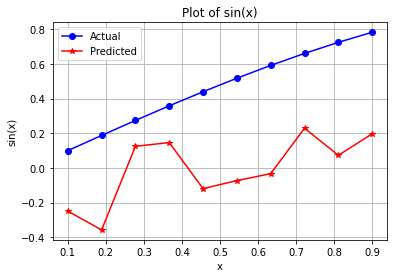

0
haha


TypeError: can only concatenate tuple (not "list") to tuple

In [24]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)#TODO:// dynamic
params = rng.random(size=shape)
# params = loaded_params
# opt = qml.GradientDescentOptimizer() #TODO:// ADAM
opt = qml.AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
print('starting plot:')
plot_u_predict(params)
for i in range(400):
    print(i)
    params, loss = opt.step_and_cost(loss_func, params)
    if i%1==0:
        print("Step ", i, "\n params = ", params,' loss = ',loss)
        plot_u_predict(params)
    

        

In [ ]:
# print(params)
# np.save("optimized_params_sin_prime.npy", params)
# loaded_params = np.load("optimized_params.npy")
# print("Loaded parameters:", loaded_params)

[[[ 0.77395605 -0.02690195  0.06878156]
  [ 0.23583767 -0.71508796  1.27560438]
  [ 0.09358354  0.77753127 -0.06614804]
  [ 0.19918381  1.27188279  0.45109944]
  [ 1.37592054  0.63255447  0.10190661]
  [ 0.04285918  0.17395651  0.30700291]]

 [[ 1.58352352  1.60506722  2.23837551]
  [ 0.71211043  1.23509285  0.61882985]
  [ 1.33904891  1.31942187 -0.50424935]
  [ 0.63697956  0.39852332  0.24006298]
  [ 1.00264411  0.69553391 -0.42386772]
  [-0.07396663  1.42778316  0.01266967]]

 [[-0.53836647  1.50436477 -0.08666687]
  [ 0.66981399  0.43715192  0.8326782 ]
  [ 0.41489892 -0.54840745  1.06235261]
  [-0.14697371  1.28598805  0.34352156]
  [ 0.6824955   0.13975248  0.1999082 ]
  [ 0.00543036  1.56591066  1.54728759]]

 [[ 0.76035884  0.78968253  0.45891578]
  [ 0.5687412   0.139797    0.11453007]
  [ 1.55083969  0.84712055  0.56523611]
  [ 0.76499886  0.63471832  0.5535794 ]
  [ 0.55920716  0.3039501   0.03081783]
  [ 0.43671739  0.21458467  0.40852864]]]
Loaded parameters: [[[ 0.7739560

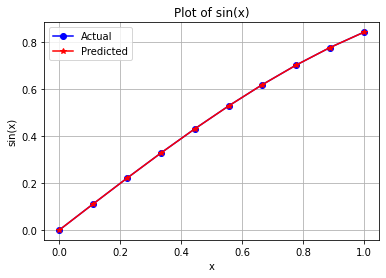

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
0.28595222510483553
0.2758089532187245


In [ ]:
plot_u_predict(loaded_params)
sample_x = np.linspace(0, 1, 10, endpoint=True)
print(sample_x)
x=0.29
print(np.sin(x))
print(u_x(parameters=loaded_params,x=x))
